## Optimal Portfolio Weights II: Rebalancing

In [2]:
# Working with data:
import numpy  as np                                   # For scientific computing.
import pandas as pd                                   # Working with tables.

# Downloading files:
import requests, zipfile, io                          # To access websites.

# Specific data providers:
from tiingo import TiingoClient                       # Stock prices.
import quandl                                         # Economic data, futures prices, ...

# API keys:
tiingo = TiingoClient({'api_key':'f10f5d79cf2567b045cc7e9b595a6fec0f5321d2'})
quandl.ApiConfig.api_key = 'EqpCyveK1jFmUkmzpPjz'

# Plotting:
import matplotlib.pyplot as plt                       # Basic plot library.
plt.style.use('ggplot')                               # Make plots look nice

### Get data

Get ETF prices and returns (GLD: Gold ETF, TLT: 20+ year treasuries, IEF: 7-10 year treasuries, SHY: 1-3 year treasuries:

In [3]:
# start in 2005 since GLD not available earlier
PRICE = tiingo.get_dataframe(['SPY','GLD','TLT'], '2005-1-1', metric_name='adjClose')
PRICE.index = pd.to_datetime(PRICE.index).tz_convert(None)
RET = PRICE.pct_change()
RET[:3]

,SPY,GLD,TLT
2005-01-03,NaN,NaN,NaN
2005-01-04,-0.012219,-0.006509,-0.010480
2005-01-05,-0.006901,-0.001638,0.005352


Get federal funds rate and treasury yields:

In [4]:
RATES = quandl.get(['FRED/FEDFUNDS','FRED/DGS1','FRED/DGS5','FRED/DGS10','FRED/DGS30']) / 100
RATES.columns = ['FedFunds','Treasury_1', 'Treasury_5', 'Treasury_10', 'Treasury_30']
RATES

,FedFunds,Treasury_1,Treasury_5,Treasury_10,Treasury_30
Date,,,,,
1954-07-01,0.0080,NaN,NaN,NaN,NaN
1954-08-01,0.0122,NaN,NaN,NaN,NaN
1954-09-01,0.0107,NaN,NaN,NaN,NaN
1954-10-01,0.0085,NaN,NaN,NaN,NaN
1954-11-01,0.0083,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2021-04-05,NaN,0.0006,0.0094,0.0173,0.0236
2021-04-06,NaN,0.0006,0.0088,0.0167,0.0232
2021-04-07,NaN,0.0006,0.0087,0.0168,0.0235


Calculate margin rate:

In [5]:
RET = RET.join(RATES.FedFunds.rename('MarginLoan'), how='outer')
RET['MarginLoan'] = RET.MarginLoan.ffill()/252 + 0.01/252           # Assume margin rate = fed funds rate + 100 bsp
RET = RET.dropna(subset=['SPY'])
RET

,SPY,GLD,TLT,MarginLoan
2005-01-04,-0.012219,-0.006509,-0.010480,0.000130
2005-01-05,-0.006901,-0.001638,0.005352,0.000130
2005-01-06,0.005084,-0.012187,0.000680,0.000130
2005-01-07,-0.001433,-0.007355,0.002264,0.000130
2005-01-10,0.004728,0.002629,0.001581,0.000130
...,...,...,...,...
2021-04-06,-0.000591,0.008029,0.006793,0.000042
2021-04-07,0.001157,-0.002818,-0.006965,0.000042
2021-04-08,0.004747,0.010752,0.008255,0.000042
2021-04-09,0.007270,-0.007538,-0.003623,0.000042


Compare stocks, long-term bonds and gold:

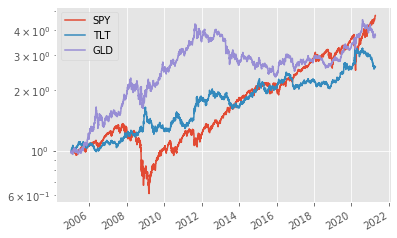

In [6]:
RET[['SPY','TLT','GLD']].add(1).cumprod().plot(logy=True)

Since 2015:

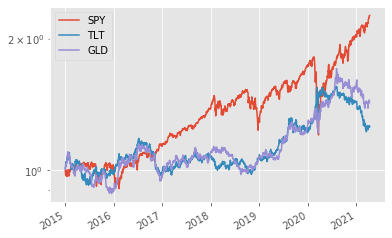

In [7]:
RET.loc['2015':,['SPY','TLT','GLD']].dropna().add(1).cumprod().plot(logy=True)

Daily correlations for each year for SPY-TLT and SPY-GLD:

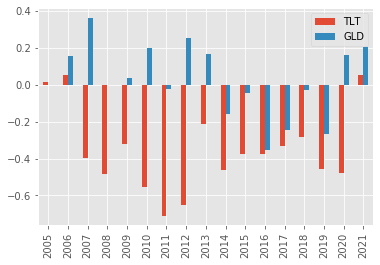

In [8]:
RET[['SPY','TLT','GLD']].groupby(RET.index.year).corr().unstack().SPY[['TLT','GLD']].plot.bar()

### Mean-variance optimization

Risk premiums and covariances:

In [10]:
r_annual       = RET[:'2020'].add(1).resample('A').prod().sub(1)
r_annual_Tbill = RATES.Treasury_1.resample('A').first()

rx_annual = r_annual.sub(r_annual_Tbill, 'rows').dropna()

meanx = rx_annual[['SPY','TLT','GLD']].mean()

cov     = RET[['SPY','TLT','GLD']].cov() * 252
cov_inv = pd.DataFrame(np.linalg.inv(cov), columns=cov.columns, index=cov.index)

meanx

SPY    0.093715
TLT    0.066050
GLD    0.089407
dtype: float64

Maximum Sharpe ratio weights:

In [15]:
w_maxSharpe = cov_inv.dot(meanx) /  cov_inv.dot(meanx).sum()
w_maxSharpe

SPY    0.355471
TLT    0.467277
GLD    0.177252
dtype: float64

Minimum volatility portfolio weights:

In [16]:
w_minVol = cov_inv.sum() / cov_inv.sum().sum()
w_minVol

SPY    0.337197
TLT    0.519308
GLD    0.143494
dtype: float64

Compound returns of optimal portfolios

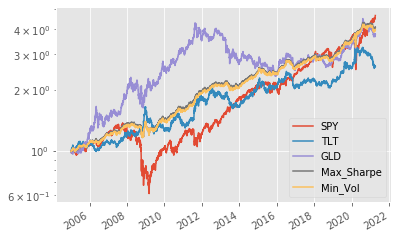

In [17]:
t = pd.DataFrame()
t['SPY']        = RET.SPY
t['TLT']        = RET.TLT
t['GLD']        = RET.GLD
t['Max_Sharpe'] = RET.multiply(w_maxSharpe).sum('columns')
t['Min_Vol']    = RET.multiply(w_minVol)   .sum('columns')

t.add(1).cumprod().plot(logy=True)

### Backtesting this strategy

In [37]:
def get_rebalance_dates(frequency):
    group = getattr(PRICE.index, frequency) 
    return PRICE[:1].index.union(PRICE.groupby([PRICE.index.year, group]).tail(1).index)



def run_backtest(frequency):   
    
    rebalance_dates = get_rebalance_dates(frequency) 

    portfolio_value = pd.Series(1,                      index=[rebalance_dates[0]])    
    weights         = pd.DataFrame(columns=RET.columns, index=[rebalance_dates[0]])
    trades          = pd.DataFrame(columns=RET.columns, index=[rebalance_dates[0]])

    previous_positions = weights.iloc[0]
        
    for i in range(len(rebalance_dates)-1):
        start_date = rebalance_dates[i]
        end_date   = rebalance_dates[i+1]

        cum_ret = RET[start_date:end_date][1:].add(1).cumprod()
        
        start_weights = select_weights(start_date)
        
        new_positions = portfolio_value.iloc[-1] * start_weights   

        start_to_end_positions = new_positions  * cum_ret
        start_to_end_value     = start_to_end_positions.sum('columns')

        portfolio_value = portfolio_value.append(start_to_end_value) 
                
        weights = weights.append(start_to_end_positions.div(start_to_end_value,'rows'))                 
                
        trades.loc[start_date] = new_positions - previous_positions 
        previous_positions     = start_to_end_positions.iloc[-1]      # Previous positions for the next rebalance round

    return portfolio_value, weights, trades

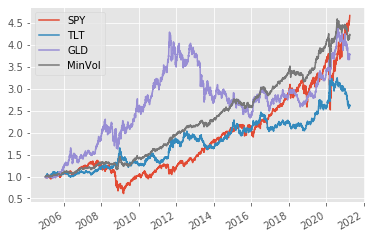

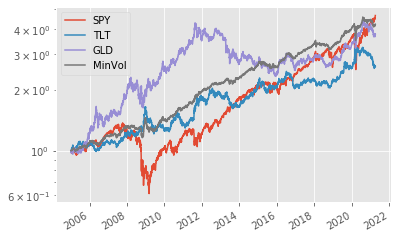

In [38]:
def select_weights(date):
    
    if not RET[:date].empty:
        cov     = RET[['SPY','TLT','GLD']][:date][-100:].cov() * 252
        cov_inv = pd.DataFrame(np.linalg.inv(cov), columns=cov.columns, index=cov.index)
        
        w = cov_inv.sum() / cov_inv.sum().sum()
        
    else:
        w = pd.Series(1/3, index = ['SPY', 'TLT', 'GLD'])
    
    
    return w




min_vol, weights, trades = run_backtest('month')


t = RET[['SPY','TLT','GLD']].join( min_vol.pct_change().rename('MinVol') )
t.add(1).cumprod().plot()
t.add(1).cumprod().plot(logy=True)

Compare Sharpe ratios for this table:

In [39]:
annual_returns = t[:'2020'].add(1).resample('A').prod().sub(1)

x = pd.DataFrame()                        
x['Average_returns']   = annual_returns.mean()
x['Geometric_average'] = annual_returns.add(1).prod().pow(1/len(annual_returns)).sub(1)
x['Risk_premium']      = annual_returns.sub(r_annual_Tbill, 'rows').dropna().mean()
x['Volatility']        = t[:'2020'].std() * 252**0.5    
x['Sharpe_ratio']      = x.Risk_premium / x.Volatility
x

,Average_returns,Geometric_average,Risk_premium,Volatility,Sharpe_ratio
SPY,0.109102,0.095103,0.093715,0.196220,0.477600
TLT,0.081438,0.071075,0.066050,0.142047,0.464988
GLD,0.104794,0.092954,0.089407,0.182457,0.490014
MinVol,0.100489,0.098068,0.085101,0.081891,1.039199


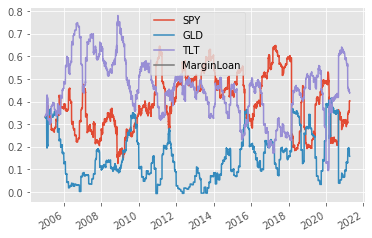

In [41]:
weights.plot()

Example weights with leverage:

In [ ]:
w = pd.Series({'SPY':0.6,'TLT':0.4})

w

Add the margin loan:

Backtest leverage:

In [ ]:

    
    
min_vol_levered, weights, trades = run_backtest('month')



t = RET[['SPY','TLT','GLD']].join( min_vol_levered.pct_change().rename('MinVol') )
t.add(1).cumprod().plot()
t.add(1).cumprod().plot(logy=True)


annual_returns = t[:'2020'].add(1).resample('A').prod().sub(1)

x = pd.DataFrame()                        
x['Average_returns']   = annual_returns.mean()
x['Geometric_average'] = annual_returns.add(1).prod().pow(1/len(annual_returns)).sub(1)
x['Risk_premium']      = annual_returns.sub(r_annual_Tbill, 'rows').dropna().mean()
x['Volatility']        = t[:'2020'].std() * 252**0.5    
x['Sharpe_ratio']      = x.Risk_premium / x.Volatility
x

Leverage ratio:

In [ ]:
weights.drop(columns=['MarginLoan'])

Compare drawdowns:

In [ ]:
hwm = t.add(1).cumprod().cummax()              # high water mark

drawdown = t.add(1).cumprod()/hwm - 1.0        # % portfolio loss relative to most recent peak (high water mark)
drawdown.plot()